<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding = "latin1")
data = data.fillna(method = "ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Number of words in corpus: ", len(data["Word"].values))
print("Unique words in corpus: ", data["Word"].nunique())
print("Unique tags in corpus: ", data["Tag"].nunique())

Number of words in corpus:  1048575
Unique words in corpus:  35178
Unique tags in corpus:  17


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
num_words

35179

In [5]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags

17

### Task 3: Retrieve Sentences and Corresponsing Tags

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                          s["POS"].values.tolist(),
                                                          s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [9]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

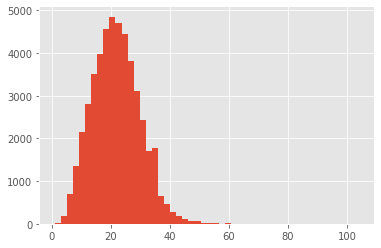

In [10]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

MAX_LENGTH = 50

x = [[word2idx[w[0]] for w in s] for s in sentences]
x = pad_sequences(sequences = x, maxlen = MAX_LENGTH, padding = "post", value = num_words - 1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(sequences = y, maxlen = MAX_LENGTH, padding = "post", value = tag2idx["O"])
y = [to_categorical(i, num_classes = num_tags) for i in y]

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [13]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape = (MAX_LENGTH, ))
model = Embedding(input_dim = num_words, output_dim = MAX_LENGTH, input_length = MAX_LENGTH)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation = "softmax"))(model)

model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           183296    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            4369      
Total params: 1,946,615
Trainable params: 1,946,615
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = "adam",
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

### Task 7: Train the Model

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

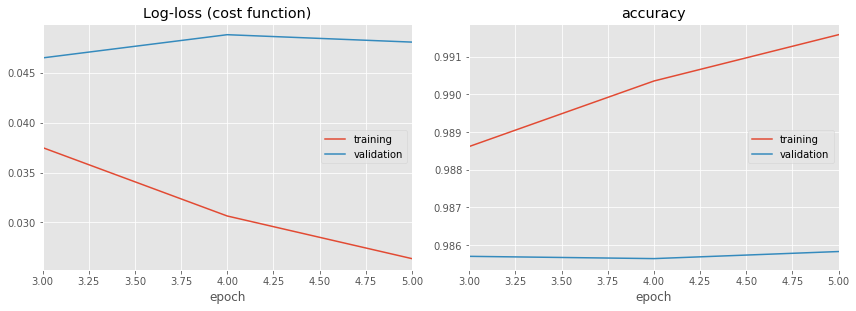

Log-loss (cost function):
training   (min:    0.026, max:    0.184, cur:    0.026)
validation (min:    0.046, max:    0.066, cur:    0.048)

accuracy:
training   (min:    0.958, max:    0.992, cur:    0.992)
validation (min:    0.981, max:    0.986, cur:    0.986)
34530/34530 [==============================] - 181s 5ms/sample - loss: 0.0264 - accuracy: 0.9916 - val_loss: 0.0481 - val_accuracy: 0.9858


In [18]:
model.fit(x_train, np.array(y_train), validation_split = 0.2, batch_size = 32, epochs = 5, verbose = 1,
         callbacks = [
             EarlyStopping(monitor = "val_accuracy", patience = 3, verbose = 0, restore_best_weights = False),
             PlotLossesCallback()
         ])

### Task 8: Evaluate Named Entity Recognition Model

In [20]:
model.evaluate(x_test, np.array(y_test), verbose = 1)

4796/4796 [==============================] - 5s 1ms/sample - loss: 0.0494 - accuracy: 0.9856


[0.049412031550025624, 0.985613]

In [25]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" * 30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{:5}\t {}\n".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            B-org	 B-org

Associated     I-org	 I-org

Press          I-org	 I-org

says           O    	 O

the            O    	 O

recommendation O    	 O

by             O    	 O

Colonel        O    	 B-org

James          B-per	 B-per

Daniel         I-per	 I-per

will           O    	 O

be             O    	 O

forwarded      O    	 O

to             O    	 O

Army           B-org	 B-org

officials      O    	 O

for            O    	 O

a              O    	 O

final          O    	 O

decision       O    	 O

.              O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron           O    	 O

Iron         